In [7]:
## source: https://www.tensorflow.org/tutorials/images/hub_with_keras

In [1]:
!pip install -q tensorflow_hub

In [5]:
from __future__ import absolute_import, division, print_function

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers

tf.VERSION

W0517 16:14:54.345613 14256 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


'1.13.1'

### Data Set ###
#### we'll use the TensorFlow flowers dataset ####

In [6]:
data_root = tf.keras.utils.get_file(
  'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

228818944/228813984 [==============================] - 120s 1us/step


In [8]:
type(data_root)

str

In [9]:
len(data_root)

46

In [11]:
#data_root # it shows the image folder path e.g. 'C:\\Users\\<usernaem>\\.keras\\datasets\\flower_photos'

In [12]:
#  load this data into our model is using tf.keras.preprocessing.image.ImageDataGenerator
# It generate batches of tensor image data with real-time data augmentation
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root))

Found 3670 images belonging to 5 classes.


In [13]:
type(image_data)

keras_preprocessing.image.directory_iterator.DirectoryIterator

In [14]:
image_data

In [16]:
# The resulting object is an iterator that returns image_batch, label_batch pairs.
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 256, 256, 3)
Label batch shape:  (32, 5)


In [17]:
# each batch - 32 images; image size - 256 x 256 x 3 (RGB); 5 classes

### Transfer Learning ###

In [22]:
# We are downloading an available image classifier from TensorFlow Hub
# https://tfhub.dev/s?module-type=image-classification
classifier_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/classification/3"
# older version: "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/2" 

In [23]:
IMAGE_SIZE = hub.get_expected_image_size(hub.Module(classifier_url))

In [24]:
IMAGE_SIZE # this is expected height, width for this classifier. 
# # A batch of images with shape [batch_size, height, width, 3] should be fed to it 

[224, 224]

In [25]:
def classifier(x):
  classifier_module = hub.Module(classifier_url) # we are using tensorflow_hub
  return classifier_module(x)

https://www.tensorflow.org/hub/api_docs/python/hub/Module
Class Module
Part of a TensorFlow model that can be transferred between models.

A Module represents a part of a TensorFlow graph that can be exported to disk (based on the SavedModel format) and later re-loaded. A Module has a defined interface that allows it to be used in a replaceable way, with little or no knowledge of its internals and its serialization format. 

In [30]:
classifier

<function __main__.classifier(x)>

In [31]:
classifier_layer = layers.Lambda(classifier, input_shape = IMAGE_SIZE+[3])
classifier_model = tf.keras.Sequential([classifier_layer])
classifier_model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 16:50:14.669631 14256 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1001)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [32]:
# so it is as if we are taking the available classifier, define appropriate input shape and create the model

In [33]:
IMAGE_SIZE+[3]

[224, 224, 3]

#### Rebuild the data generator ####

In [34]:
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break

Found 3670 images belonging to 5 classes.
Image batch shape:  (32, 224, 224, 3)
Labe batch shape:  (32, 5)


In [35]:
# NOW each batch - 32 images; image size - 224 x 224 x 3 (RGB); 5 classes

In [36]:
# When using Keras, TFHub modules need to be manually initialized.
import tensorflow.keras.backend as K
sess = K.get_session()
init = tf.global_variables_initializer()

sess.run(init)

65536/61306 [================================] - 0s 3us/step


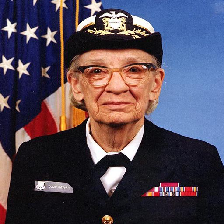

In [37]:
# download a single image and try the model
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SIZE)
grace_hopper 

In [38]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [39]:
# Add a batch dimension, and pass the image to the model.

In [40]:
grace_hopper[np.newaxis, ...].shape

(1, 224, 224, 3)

np.newaxis

the newaxis is used to increase the dimension of the existing array by one more dimension, when used once. Thus,

1D array will become 2D array

2D array will become 3D array

3D array will become 4D array

4D array will become 5D array

In [41]:
result = classifier_model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [42]:
# The result is a 1001 element vector of logits, rating the probability of each class for the image.
# So the top class ID can be found with argmax:

In [43]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

In [44]:
# Decode the predictions
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


In [46]:
predicted_class_name = imagenet_labels[predicted_class]
predicted_class_name

'military uniform'

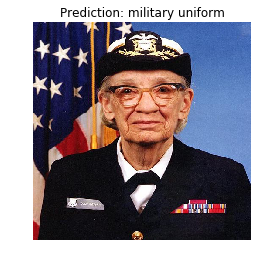

In [47]:
plt.imshow(grace_hopper)
plt.axis('off')
_ = plt.title("Prediction: " + predicted_class_name)

### Run on batch of images ###

In [49]:
image_batch.shape

(32, 224, 224, 3)

In [50]:
result_batch = classifier_model.predict(image_batch)

In [51]:
result_batch.shape

(32, 1001)

In [52]:
labels_batch = imagenet_labels[np.argmax(result_batch, axis=-1)]
labels_batch

array(['vase', 'sea urchin', 'bell pepper', 'vase', 'daisy', 'bee',
       'artichoke', 'daisy', 'mushroom', 'greenhouse', 'bee',
       'picket fence', "jack-o'-lantern", 'daisy', 'mountain tent',
       'daisy', 'daisy', 'daisy', 'daisy', 'daisy', 'tray', 'cardoon',
       'pot', 'junco', 'picket fence', 'daisy', 'horse cart',
       'spider web', 'daisy', 'greenhouse', 'bee', 'sea urchin'],
      dtype='<U30')

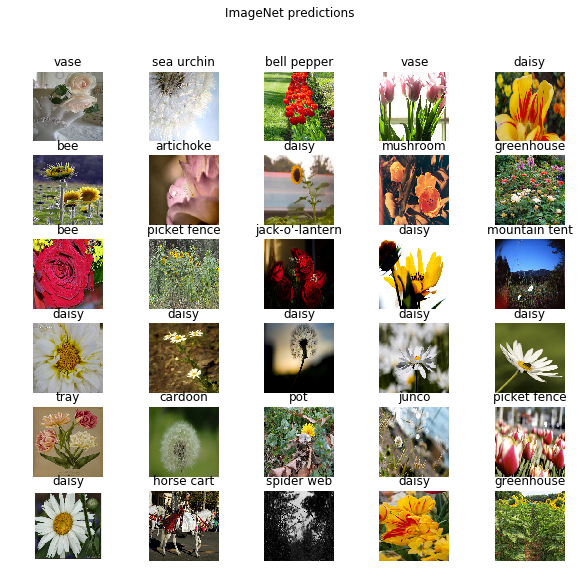

In [53]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

In [54]:
# SO we downloaded a model and used it

### Simple Transfer Learning ###

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

In [57]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/3" 
# its a different URL from previous section

# older: "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2" 

In [58]:
def feature_extractor(x):
  feature_extractor_module = hub.Module(feature_extractor_url)
  return feature_extractor_module(x)

In [59]:
IMAGE_SIZE = hub.get_expected_image_size(hub.Module(feature_extractor_url))
IMAGE_SIZE

[224, 224]

In [60]:
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Labe batch shape: ", label_batch.shape)
  break

Found 3670 images belonging to 5 classes.
Image batch shape:  (32, 224, 224, 3)
Labe batch shape:  (32, 5)


In [61]:
features_extractor_layer = layers.Lambda(feature_extractor, input_shape=IMAGE_SIZE+[3])

In [62]:
features_extractor_layer.trainable = False # we'll train only our own last layer

In [63]:
# define our model
model = tf.keras.Sequential([
  features_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax') # basically we are adding a Dense softmax layer
])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0517 17:26:50.239166 14256 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 6,405
Trainable params: 6,405
Non-trainable params: 0
_________________________________________________________________


In [64]:
# Initialize the TFHub module.
init = tf.global_variables_initializer()
sess.run(init)

In [65]:
# Test run a single batch, to see that the result comes back with the expected shape.
result = model.predict(image_batch)
result.shape

(32, 5)

In [66]:
result # we have not trained the last layer yet - so this result is not useful

array([[0.10686507, 0.4062917 , 0.07849845, 0.14043322, 0.26791152],
       [0.2918518 , 0.17598873, 0.31733367, 0.15487541, 0.05995046],
       [0.12499551, 0.14955635, 0.3322823 , 0.28566292, 0.10750288],
       [0.33261818, 0.1935721 , 0.23415516, 0.18036896, 0.05928547],
       [0.36073378, 0.17518839, 0.17442939, 0.14037614, 0.14927223],
       [0.20054844, 0.28031576, 0.13401198, 0.1124884 , 0.2726354 ],
       [0.40350667, 0.06871416, 0.25432047, 0.12070338, 0.15275538],
       [0.04079699, 0.09042364, 0.1155552 , 0.2196409 , 0.5335833 ],
       [0.06406866, 0.15001899, 0.5309834 , 0.20704845, 0.04788054],
       [0.06724656, 0.343501  , 0.20947532, 0.06881473, 0.31096247],
       [0.05125307, 0.15233333, 0.2502323 , 0.03853176, 0.5076496 ],
       [0.09157863, 0.35518134, 0.08595725, 0.31195447, 0.15532829],
       [0.09947741, 0.04059271, 0.16829476, 0.61965287, 0.07198231],
       [0.11808275, 0.06134241, 0.40489915, 0.10941196, 0.30626374],
       [0.06074192, 0.2067245 , 0.

### Train the Model ###

In [67]:
model.compile(
  optimizer=tf.train.AdamOptimizer(), 
  loss='categorical_crossentropy',
  metrics=['accuracy'])

In [68]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    
  def on_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])

In [69]:
steps_per_epoch = image_data.samples//image_data.batch_size
batch_stats = CollectBatchStats()
model.fit((item for item in image_data), epochs=1, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats])

Instructions for updating:
Use tf.cast instead.


W0517 17:31:38.990038 14256 deprecation.py:323] From C:\Users\einchat\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


114/114 [==============================] - 213s 2s/step - loss: 0.6682 - acc: 0.7686


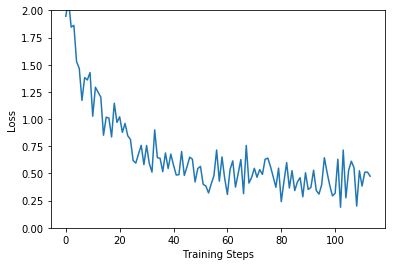

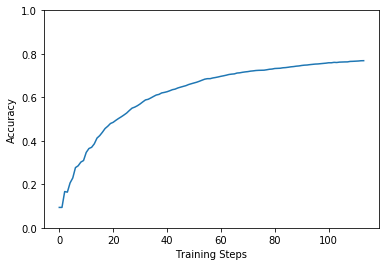

In [70]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats.batch_acc)

### Prediction ###

In [74]:
image_data.class_indices
# https://keras.io/preprocessing/image/
# The dictionary containing the mapping from class names to class indices can be obtained via the attribute class_indices

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [75]:
image_data.class_indices.items()

dict_items([('daisy', 0), ('dandelion', 1), ('roses', 2), ('sunflowers', 3), ('tulips', 4)])

In [76]:
label_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])
label_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [77]:
result_batch = model.predict(image_batch)

labels_batch = label_names[np.argmax(result_batch, axis=-1)]
labels_batch

array(['Sunflowers', 'Roses', 'Daisy', 'Tulips', 'Tulips', 'Tulips',
       'Roses', 'Dandelion', 'Sunflowers', 'Sunflowers', 'Sunflowers',
       'Dandelion', 'Roses', 'Sunflowers', 'Dandelion', 'Daisy', 'Tulips',
       'Tulips', 'Tulips', 'Dandelion', 'Sunflowers', 'Daisy', 'Tulips',
       'Tulips', 'Tulips', 'Roses', 'Roses', 'Tulips', 'Tulips', 'Tulips',
       'Daisy', 'Tulips'], dtype='<U10')

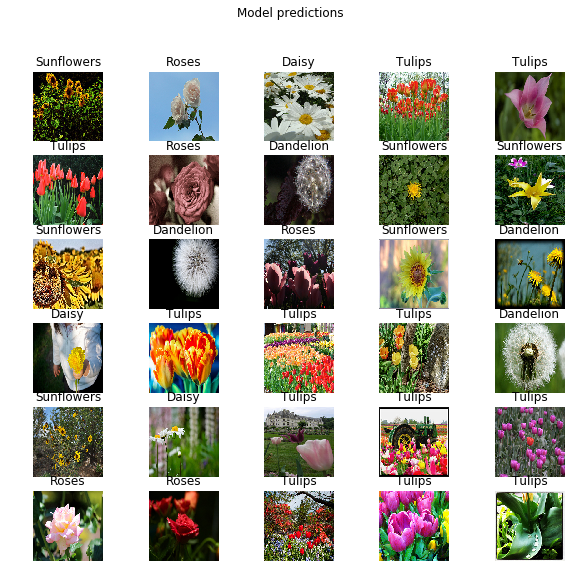

In [78]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
_ = plt.suptitle("Model predictions")

## We took an available model, then used our own last layer, trained and used it ##
## Thus we learnt about Transfer Learning ##